# Correlate timecourses with templates  

Use the z-scored timeseries to correlate one patient's individual volumes with the average activity maps of the other patients.

### import modules

In [2]:
import os
import pickle

import numpy as np
import pandas as pd

from nilearn import input_data, plotting, image

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('poster')

In [ ]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

### get data

In [6]:
data_df = pd.read_csv(
    '../data/interim/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_df.csv',
    index_col=[0],
    header=0)

data_df.index = [data_df.loc[:, 'wada'], data_df.index]
data_df = data_df.sort_index()

In [7]:
data_df.shape

(96, 15)

In [ ]:
data_df[::20]

### masker

#### whole brain masker

In [13]:
mask_file = os.path.join(supDir,'data','external','MNI152_T1_2mm_brain_mask.nii.gz')
whole_brain_masker = input_data.NiftiMasker(mask_file).fit()

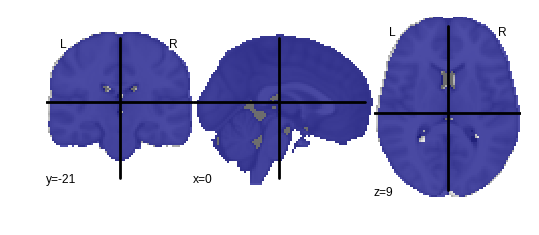

In [14]:
plotting.plot_roi(whole_brain_masker.mask_img_)

#### template image from our previous work (independent patient sample)

In [15]:
template_im = os.path.join(supDir,'models','tMap_diff_left.nii.gz')

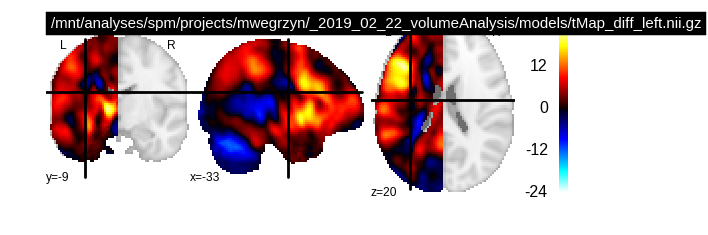

In [16]:
plotting.plot_stat_map(template_im,title=template_im)

### make mask with all positive values

In [17]:
data = whole_brain_masker.transform(template_im)

In [18]:
my_data = data>0

In [19]:
template_mask = whole_brain_masker.inverse_transform(my_data)
masker = input_data.NiftiMasker(template_mask).fit()

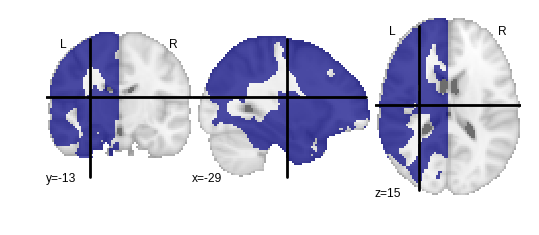

In [20]:
plotting.plot_roi(masker.mask_img_)

### get data from mask

In [21]:
template_df = pd.DataFrame(masker.transform(template_im),index=['template'])
template_df

,0,1,2,3,4,5,6,7,8,9,...,83348,83349,83350,83351,83352,83353,83354,83355,83356,83357
template,3.445243,3.614059,3.326242,3.111461,4.105546,4.867407,4.707578,3.900402,3.285692,3.031834,...,5.437006,5.590981,4.221958,4.216458,3.891765,4.063703,4.220668,3.81145,3.704904,3.586174


### get data from target patient

We get every single volume

In [22]:
def make_timecourse_df(this_idx, col_name, data_df=data_df, masker=masker):
    """extract data from 4d-image. The image is taken from the data_df table"""

    # select the image using row and column indexing
    this_im = data_df.loc[this_idx, col_name]
    # extract whole-brain data
    this_data = masker.transform(this_im)
    # transform into df with default numbering of rows and columns
    this_df = pd.DataFrame(this_data)

    return this_df

In [23]:
p_name = data_df.index[0]

In [24]:
this_df = make_timecourse_df(p_name, 'z-scored-diff')

In [25]:
this_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,83348,83349,83350,83351,83352,83353,83354,83355,83356,83357
195,-1.511155,-1.652787,-1.653670,-1.309035,-0.887515,-0.704757,-0.732513,-0.940532,-1.141126,-1.318399,...,-1.498128,-0.963594,-0.311721,-1.082781,-1.705738,-2.097711,-0.420550,-0.983460,-1.540432,-0.563722
196,-0.544567,-0.344865,0.033174,0.366556,0.583479,0.366686,0.325798,-0.412496,-0.430490,-0.179970,...,-0.250426,0.459584,-0.338515,-0.659174,-0.747237,-1.120024,-0.389533,-0.828307,-0.980258,-1.005727
197,-1.114126,-1.047489,-0.981307,0.538228,0.327205,0.057783,-1.063272,-0.387243,-0.415092,-0.323302,...,-1.963384,-3.019014,0.446297,-0.065178,-0.207539,0.189219,0.990086,0.749926,0.639689,2.157762
198,-0.026903,-0.130909,-0.238522,0.921687,0.966985,0.813078,-0.997145,0.347042,0.312118,0.410361,...,0.511891,0.162988,0.558021,0.418361,0.467251,0.736883,0.144875,-0.046631,-0.063275,-0.487398
199,-0.386259,-0.256826,-0.041588,-0.165666,0.065574,0.242060,-2.392921,0.336305,0.383925,0.504428,...,-0.173004,0.020098,1.602774,0.852011,0.119948,-0.451068,1.845974,0.933474,0.080386,0.088990


#### toolbox version

In [28]:
#def make_timecourse_df(pFolder,pName, masker=masker):
#
#    this_im = os.path.join(pFolder, ''.join(['z_imDiff_', pName, '.nii.gz']))
#    this_data = masker.transform(this_im)
#    this_df = pd.DataFrame(this_data)
#
#    return this_df

### correlate each individual volume of a patient with the template

In [26]:
def make_corrs(this_df, template_df):
    """correlate each volume of target patient with template"""

    d = {}

    for vol in this_df.index:

        this_vol = this_df.loc[vol, :]
        d[vol] = {}
        all_corrs = np.corrcoef(this_vol, template_df)
        my_corrs = all_corrs[0, 1:]
        for n, i in enumerate(template_df.index):
            d[vol][i] = my_corrs[n]

    df = pd.DataFrame(d)

    return df

In [27]:
from datetime import datetime

In [28]:
print('%s'%datetime.now())
corr_df = make_corrs(this_df, template_df)
print('%s'%datetime.now())

2019-04-05 17:47:01.476950
2019-04-05 17:47:01.730874


In [29]:
corr_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
template,0.098187,0.035327,0.010837,0.012339,0.0389,0.019638,0.050094,0.026805,-0.060934,-0.005521,...,-0.064179,-0.018042,-0.00483,-0.039661,-0.08341,-0.058365,-0.00934,-0.003954,0.028095,0.012717


In [3]:
with open('../models/colors.p', 'rb') as f:
    color_dict = pickle.load(f)

In [4]:
#### selection of main colors  
my_cols = {}
for i, j in zip(['red', 'blue', 'yellow'], ['left', 'right', 'bilateral']):
    my_cols[j] = color_dict[i]

my_cols

{'left': (0.8313725490196079, 0.16470588235294117, 0.12549019607843137),
 'right': (0.054901960784313725, 0.38823529411764707, 0.5568627450980392),
 'bilateral': (0.9803921568627451, 0.7607843137254902, 0.16862745098039217)}

### make individual plot

In [29]:
with open('../models/conds.p', 'rb') as f:
    conds = pickle.load(f)

In [30]:
def make_plot(df, ax, color_dict=color_dict, conds=conds):
    """show correlations of single patient's volumes with groups"""

    # find the volumes when activity starts (CAVE: make sure that blocks
    # are 10 volumes long, because this is hard-coded here)
    act_blocks = np.where(np.array(conds) == 1)[-1][::10]

    # draw each block with height -1 to +1 (needs to be trimmed to actual
    # data range later, otherwise too large)
    for i in act_blocks:
        ax.fill_between([i, i + 10], [-1, -1], [1, 1],
                        color=color_dict['trans'],
                        alpha=0.7)

    # the correlations with each group are in rows, we loop through each group/row
    for i in df.index:
        ax.plot(
            df.loc[i, :], label=i, alpha=0.8, linewidth=4, color=color_dict['blue'])

    # dotted line indicates zero/no correlation
    ax.axhline(0, linestyle=':', color=color_dict['black'], linewidth=3)

    # define range on y-axis by rounded-up max value
    my_max = (df.max().max() + 0.05).round(1)
    ax.set_ylim(-my_max, my_max)
    ax.set_yticks(np.linspace(-my_max, my_max, 5))

    ax.set_xlim(0, 200)
    ax.set_xticks(np.arange(0, 201, 20))

    #ax.legend(loc='best', fontsize=20)

    ax.set_xlabel('Volume/TR')
    ax.set_ylabel('Pearson Correlation')

    sns.despine(trim=True, offset=10)

    return ax

### do everything for one patient

In [35]:
def make_p(p_name):
    """everything for one patient"""

    this_df = make_timecourse_df(p_name, 'z-scored-diff')
    corr_df = make_corrs(this_df, template_df)

    return corr_df

In [36]:
print('%s'%datetime.now())
p_df = make_p(p_name)
print('%s'%datetime.now())

2019-04-05 17:48:27.835128
2019-04-05 17:48:40.347240


In [37]:
p_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
template,0.098187,0.035327,0.010837,0.012339,0.0389,0.019638,0.050094,0.026805,-0.060934,-0.005521,...,-0.064179,-0.018042,-0.00483,-0.039661,-0.08341,-0.058365,-0.00934,-0.003954,0.028095,0.012717


#### toolbox version

In [ ]:
#def make_p(pFolder,pName,template_df=template_df,masker=masker):
#
#    this_df = make_timecourse_df(pFolder, pName, masker=masker)
#    corr_df = make_corrs(this_df, template_df)
#    out_name = os.path.join(pFolder, ''.join([ pName, '_corr_df.csv']))
#    corr_df.to_csv(out_name)
#    
#    return out_name

### show individual results

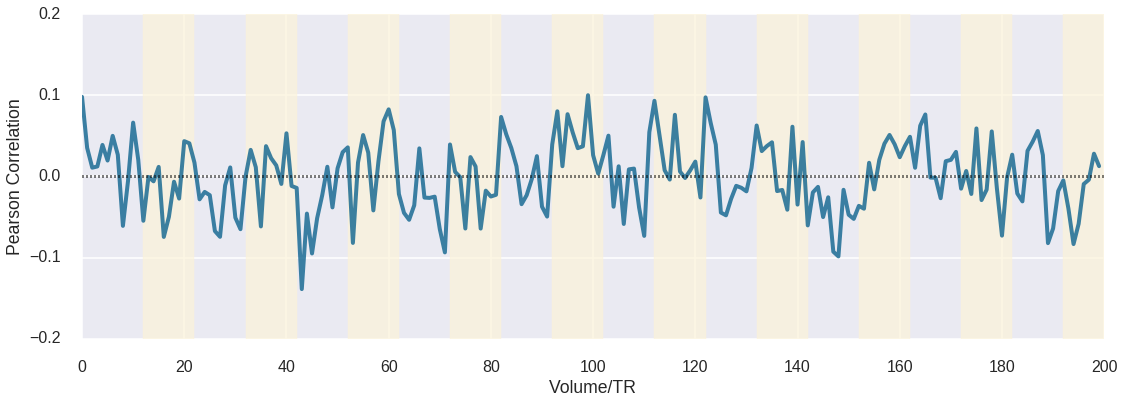

In [34]:
fig,ax = plt.subplots(1,1,figsize=(16, 6))
ax = make_plot(p_df, ax=ax)
plt.tight_layout()
plt.show()

### do this for all patients

In [ ]:
#for p_name in tqdm(data_df.index):
for p_name in data_df.index:
    print('%s %s'%(p_name,datetime.now()))
    
    p_df = make_p(p_name)
    out_name = '../data/interim/csv/%s_corr_df.csv' % p_name[-1]
    p_df.to_csv(out_name)
    data_df.loc[p_name,'corr_df'] = out_name

data_df.to_csv('../data/interim/csv/info_epi_zscored_zdiff_summarymaps_2dpredclean_corr_df.csv')

### summary

We now have a table for each patient, where the correlations of each of the 200 volumes with the template are stored.


**************

< [Previous](08-mw-methods-plot-correlations.ipynb) | [Contents](00-mw-overview-notebook.ipynb) | [Next >](10-mw-train-test-classifier.ipynb)